# Imports

In [3]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl

# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))

import importlib
import graphs as g
import utils as u
import processing as p
import model as m
import selection as s

# Data

In [4]:
train_data = pd.read_json('input/train.json')
train_data.sort_index()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [5]:
test_data = pd.read_json('input/test.json')
test_data.sort_index()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


# Feature extraction

In [6]:
import re

def feature(text):
    if '*' in text:
        return ''
    else:
        text = list(filter(lambda t: len(t) < 11, text))
        return ','.join(text).lower()

train_data['features'] = train_data.features.map(lambda f: ','.join(f))
test_data['features'] = test_data.features.map(lambda f: ','.join(f))

In [177]:
importlib.reload(p)

managers = train_data.manager_id.append(test_data.manager_id).values
manager_le = p.label_encoder(managers, 'managers')

buildings = train_data.building_id.append(test_data.building_id).values
building_le = p.label_encoder(buildings, 'buildings')

addresses = train_data.display_address.append(test_data.display_address).values
address_le = p.label_encoder(addresses, 'addresses')

stop_words = ['fee', 'pre', 'post','exclusive', 'ok', 'sq', 'allowed', 'new']
features = train_data.features.append(test_data.features).values
features_we = p.word_encoder(features, title='features', stop_words=stop_words, max_features=10)

stop_words = ['br', 'li', 'text']
desc = train_data.description.append(test_data.description).values
desc_we = p.word_encoder(desc, title='description', stop_words=stop_words, max_features=10)

managers: 4399 
buildings: 11635 
addresses: 16068 
features: ['building', 'cats', 'dishwasher', 'dogs', 'doorman', 'elevator', 'fitness', 'floors', 'hardwood', 'laundry'] 
description: ['apartment', 'appliances', 'bedroom', 'building', 'com', 'floors', 'hardwood', 'kitchen', 'new', 'website_redacted'] 


In [8]:
from datetime import datetime

# train
# train_data['created'] = train_data['created'].map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S').month)
train_data['manager_id'] = manager_le.transform(train_data.manager_id)
train_data['building_id'] = building_le.transform(train_data.building_id)
train_data['display_address'] = address_le.transform(train_data.display_address)
train_data['interest_level'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace=True)

# test
test_data['manager_id'] = manager_le.transform(test_data.manager_id)
test_data['building_id'] = building_le.transform(test_data.building_id)
test_data['display_address'] = address_le.transform(test_data.display_address)


In [178]:
test_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,5535,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,13274,"Elevator,Laundry in Building,Laundry in Unit,D...",40.7185,7142618,-73.9865,3076,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,13391,"Pre-War,Dogs Allowed,Cats Allowed",40.7278,7210040,-74.0000,3593,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,2813,2016-06-03 04:29:40,New York chic has reached a new level ...,990,"Doorman,Elevator,No Fee",40.7306,7103890,-73.9890,2677,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,5477,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,481,"Roof Deck,Balcony,Elevator,Laundry in Building...",40.7109,7143442,-73.9571,201,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,4428,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...",12317,"Common Outdoor Space,Cats Allowed,Dogs Allowed...",40.7650,6860601,-73.9845,3157,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


In [10]:
# features = train_data.features.str.get_dummies(',')
# features.columns[100:400]
# train_data.features[100:200]
# features.shape

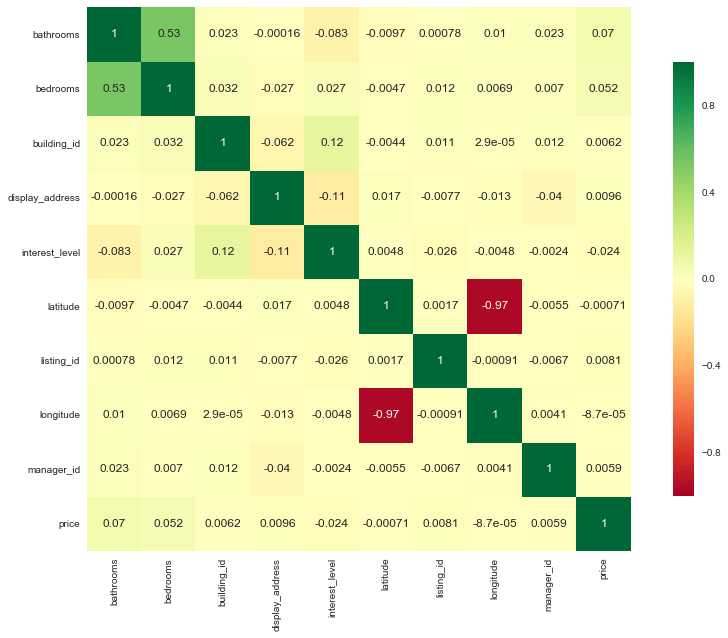

In [11]:
g.plot_correlation_map(train_data)

# Feature selection

In [142]:
labels_names = ['low', 'medium', 'high']
labels_columns = ['interest_level']
y = train_data[labels_columns]
u.log('y', y.shape)

y: (49352, 1) 


In [13]:
importlib.reload(p)

features_columns = ['building_id', 'display_address', 'manager_id']
features_count = len(features_columns)

xx1 = train_data[features_columns]
x1 = pd.DataFrame(p.scale(xx1)[0], index=train_data.index)

xx1_test = test_data[features_columns]
x1_test = pd.DataFrame(p.scale(xx1_test)[0], index=test_data.index)

# g.plot_univariate_scores(xx1, y, xx1.columns)
# x1

X: (49352, 3) 
X: (74659, 3) 


In [180]:
importlib.reload(s)

features_features = features_we.get_feature_names()

fa = features_we.transform(train_data.features.values).toarray()
xf = pd.DataFrame(fa, columns=features_features, index=train_data.index)
x2, selector = s.kbest_filter(xf, y, features_features, k=10)

selected_features = s.selected_features(selector, features_features)

fa_test = features_we.transform(test_data.features.values).toarray()
xf_test = pd.DataFrame(fa_test, columns=features_features, index=test_data.index)
x2_test = pd.DataFrame(selector.transform(xf_test), columns=selected_features, index=test_data.index)

# g.plot_univariate_scores(x2, y, x2.columns)
# x2
x2_test.shape

X: (49352, 10) 


(74659, 10)

In [181]:
importlib.reload(s)

desc_features = desc_we.get_feature_names()

da = desc_we.transform(train_data.description.values).toarray()
xd = pd.DataFrame(da, columns=desc_features, index=train_data.index)
x3, selector = s.kbest_filter(xd, y, desc_features, k=10)

selected_features = s.selected_features(selector, desc_features)

da_test = desc_we.transform(test_data.description.values).toarray()
xd_test = pd.DataFrame(da_test, columns=desc_features, index=test_data.index)
x3_test = pd.DataFrame(selector.transform(xd_test), columns=selected_features, index=test_data.index)

# g.plot_univariate_scores(x3, y, x3.columns)
# x3
x3_test.shape

X: (49352, 10) 


(74659, 10)

In [182]:
importlib.reload(p)

x = pd.DataFrame(index=train_data.index)
x_test = pd.DataFrame(index=test_data.index)

x = pd.merge(x, x1, left_index=True, right_index=True)
x = pd.merge(x, x2, left_index=True, right_index=True)
x = pd.merge(x, x3, left_index=True, right_index=True)

x_test = pd.merge(x_test, x1_test, left_index=True, right_index=True)
x_test = pd.merge(x_test, x2_test, left_index=True, right_index=True)
x_test = pd.merge(x_test, x3_test, left_index=True, right_index=True)

X = x.as_matrix()
X_test = x_test.as_matrix()

Y = p.onehot(y)

u.log('X', X.shape)
u.log('X test', X_test.shape)

u.log('X', X[:2])
u.log('Y', Y[:2])

Y: (49352, 3) 
X: (49352, 23) 
X test: (74659, 23) 
X: [[ 0.32639904  0.76447155  0.35660678  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          1.
   1.          1.          0.          0.          1.          1.          1.
   1.          1.        ]
 [ 0.77245766  0.56516868  0.45212645  0.          1.          0.          1.
   1.          1.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]] 
Y: [[ 0.  1.  0.]
 [ 1.  0.  0.]] 


# Model

In [183]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape {}'.format(Counter(y.interest_level)))
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3)
    
Y_train = p.onehot(y_train)
Y_val = p.onehot(y_val)

u.log('X train', X_train.shape)
u.log('y train', y_train.shape)
u.log('Y train', Y_train.shape)

u.log('X val', X_val.shape)
u.log('y val', y_val.shape)
u.log('Y val', Y_val.shape)

Original dataset shape Counter({0: 34284, 1: 11229, 2: 3839})
Resampled dataset shape Counter({2: 3839, 1: 3839, 0: 3839})
Y: (8061, 3) 
Y: (3456, 3) 
X train: (8061, 23) 
y train: (8061,) 
Y train: (8061, 3) 
X val: (3456, 23) 
y val: (3456,) 
Y val: (3456, 3) 


/Users/icostan/Work/kaggle/ENV/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [184]:
importlib.reload(m)
from keras import optimizers
from keras import callbacks

class_weights = u.get_class_weights(y.interest_level, smooth_factor=0.1)
tb = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
callbacks = []

model = m.keras_classification(X.shape[1], Y.shape[1])
optimizer = optimizers.Adam(lr=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, callbacks=callbacks)
model.save('rental.h5')

result = model.evaluate(X_val, Y_val, verbose=1)
print('')
u.log(model.metrics_names, result)

# plt.figure(figsize=(12,8))
# g.plot_accuracy(history)
# g.plot_loss(history)

Epoch 1/10
8061/8061 [==============================] - 1s - loss: 1.1379 - acc: 0.3495       

Logloss: 1.12526435307 
R:              precision    recall  f1-score   support

        low       0.35      0.59      0.43      1137
     medium       0.36      0.41      0.38      1155
       high       0.38      0.08      0.13      1164

avg / total       0.36      0.35      0.31      3456
 
Confusion matrix, without normalization
[[666 390  81]
 [618 469  68]
 [646 428  90]]


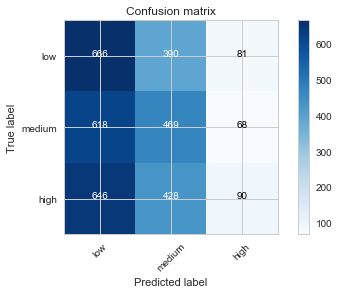

In [185]:
y_val_prob = model.predict(X_val, verbose=0)
y_val_pred = np.reshape(np.argmax(y_val_prob, axis=1), (-1, 1))

# u.log('Y Val', y_val[:3])
# u.log('Y Val hot', Y_val[:3])

# u.log('Y Val prob', Y_val_prob[:3])
# u.log('Y Val pred', y_val_pred[:3])

u.log('Logloss', log_loss(y_val, y_val_prob))
u.log('R', classification_report(y_val, y_val_pred, target_names=labels_names))

cm = confusion_matrix(y_val, y_val_pred)
g.plot_confusion_matrix(cm, labels_names)

In [186]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, random_state=6)
clf.fit(X_train, y_train)

u.log('Classes', clf.classes_)

Classes: [0 1 2] 


LogLoss: 0.916365893007 
R:              precision    recall  f1-score   support

        low       0.62      0.59      0.61      1137
     medium       0.50      0.51      0.50      1155
       high       0.54      0.55      0.55      1164

avg / total       0.55      0.55      0.55      3456
 
Confusion matrix, without normalization
[[673 267 197]
 [215 592 348]
 [190 332 642]]


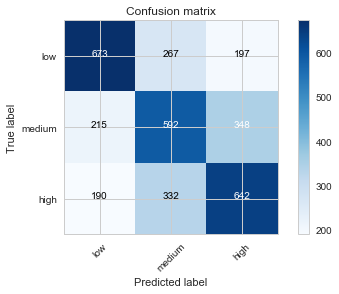

In [187]:
importlib.reload(g)

y_val_prob = clf.predict_proba(X_val)
y_val_pred = np.reshape(np.argmax(y_val_prob, axis=1), (-1, 1))

# print(y_val.shape)
# print(y_val_pred.shape)
# print(y_val_prob.shape)

u.log('LogLoss', log_loss(y_val, y_val_prob))
u.log('R', classification_report(y_val, y_val_pred, target_names=labels_names))

cm = confusion_matrix(y_val, y_val_pred)
g.plot_confusion_matrix(cm, labels_names)

# Prediction


In [244]:
YY = model.predict(XX)
print(YY.shape)
print(YY[:10])

(74659, 3)
[[ 0.31261647  0.37511638  0.31226721]
 [ 0.71323466  0.17497879  0.11178662]
 [ 0.53717238  0.19526769  0.26755989]
 [ 0.26491058  0.45452172  0.28056774]
 [ 0.28420055  0.40922543  0.30657402]
 [ 0.38816887  0.38215137  0.22967976]
 [ 0.31628162  0.39394382  0.28977454]
 [ 0.29942057  0.32414582  0.37643358]
 [ 0.62552339  0.23341587  0.14106072]
 [ 0.31701413  0.43529797  0.24768785]]


In [188]:
yy = clf.predict(X_test)
print(yy.shape)
print(yy[:10])

YY = clf.predict_proba(X_test)
print(YY.shape)
print(YY[:10])

(74659,)
[1 0 0 2 1 1 0 2 2 2]
(74659, 3)
[[ 0.2655      0.36766667  0.36683333]
 [ 0.824       0.081       0.095     ]
 [ 0.524       0.20533333  0.27066667]
 [ 0.149       0.29658333  0.55441667]
 [ 0.23932106  0.60079084  0.1598881 ]
 [ 0.34333333  0.42620238  0.23046429]
 [ 0.688       0.1215      0.1905    ]
 [ 0.2925      0.25661667  0.45088333]
 [ 0.22058333  0.33941667  0.44      ]
 [ 0.21        0.2535      0.5365    ]]


# Submission

In [189]:
import time
sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['listing_id', 'high', 'medium', 'low'])
submission.listing_id = sample.listing_id
submission.low = YY[:,0]
submission.medium = YY[:,1]
submission.high = YY[:,2]
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(74659, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Data columns (total 4 columns):
listing_id    74659 non-null int64
high          74659 non-null float64
medium        74659 non-null float64
low           74659 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.3 MB


# References

* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id/
* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/some-insights-on-building-id
* https://www.kaggle.com/sudalairajkumar/two-sigma-connect-rental-listing-inquiries/simple-exploration-notebook-2-connect/notebook
* https://www.kaggle.com/guoday/two-sigma-connect-rental-listing-inquiries/cv-statistics-better-parameters-and-explaination/notebook
* https://www.kaggle.com/lxs0202/two-sigma-connect-rental-listing-inquiries/neighborhoods-instead-of-lat-long